In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import random
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, roc_auc_score, recall_score, classification_report, silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 데이터 불러오기

In [ ]:
DATA_PATH = "/content/drive/MyDrive/멋쟁이사자처럼/DataThon/dataset/Moulding/"
SEED = 42
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_cn7 = pd.read_csv(f"{DATA_PATH}train_cn7.csv")    # 정상 0
test_cn7 = pd.read_csv(f"{DATA_PATH}test_cn7.csv")  # 정상 0 + 불량 1
train_rg3 = pd.read_csv(f"{DATA_PATH}train_rg3.csv")    # 정상 0
test_rg3 = pd.read_csv(f"{DATA_PATH}test_rg3.csv")  # 정상 0 + 불량 1
unlabeled = pd.read_csv(f"{DATA_PATH}unlabeled_data.csv")
unlab_cn7 = pd.read_csv(f"{DATA_PATH}unlab_cn7.csv")
unlab_rg3 = pd.read_csv(f"{DATA_PATH}unlab_rg3.csv")

train_cn7.shape, test_cn7.shape, train_rg3.shape, test_rg3.shape, unlab_cn7.shape, unlab_rg3.shape

((2400, 45), (1574, 45), (750, 45), (506, 45), (52547, 46), (37477, 46))

In [ ]:
# cn7_name = ["CN7 W/S SIDE MLD'G LH", "CN7 W/S SIDE MLD'G RH"]
# rg3_name = ["RG3 MOLD'G W/SHLD, LH", "RG3 MOLD'G W/SHLD, RH"]

# unlab_cn7 = unlabeled[unlabeled["PART_NAME"].isin(cn7_name)]
# unlab_rg3 = unlabeled[unlabeled["PART_NAME"].isin(rg3_name)]

# unlab_cn7["PART_NAME"].value_counts(), unlab_rg3["PART_NAME"].value_counts()

In [ ]:
# unlab_cn7.to_csv(f"{DATA_PATH}unlab_cn7.csv", index=False)
# unlab_rg3.to_csv(f"{DATA_PATH}unlab_rg3.csv", index=False)

In [ ]:
train_cn7['PART_FACT_SERIAL'] = train_cn7['PART_FACT_SERIAL'].astype(object)
test_cn7['PART_FACT_SERIAL'] = test_cn7['PART_FACT_SERIAL'].astype(object)
train_rg3["PART_FACT_SERIAL"] = train_rg3["PART_FACT_SERIAL"].astype(object)
test_rg3["PART_FACT_SERIAL"] = test_rg3["PART_FACT_SERIAL"].astype(object)
unlab_cn7["PART_FACT_SERIAL"] = unlab_cn7["PART_FACT_SERIAL"].astype(object)
unlab_rg3["PART_FACT_SERIAL"] = unlab_rg3["PART_FACT_SERIAL"].astype(object)

In [ ]:
train_cn7["PassOrFail"] = (train_cn7["PassOrFail"]=="N").astype(int)
test_cn7["PassOrFail"] = (test_cn7["PassOrFail"]=="N").astype(int)

train_rg3["PassOrFail"] = (train_rg3["PassOrFail"]=="N").astype(int)
test_rg3["PassOrFail"] = (test_rg3["PassOrFail"]=="N").astype(int)

In [ ]:
tr_target_cn7 = train_cn7['PassOrFail']
tr_target_rg3 = train_rg3['PassOrFail']

tr_target_cn7.shape, tr_target_rg3.shape

((2400,), (750,))

In [ ]:
target_cn7 = test_cn7['PassOrFail']
target_rg3 = test_rg3['PassOrFail']

target_cn7.shape, target_rg3.shape

((1574,), (506,))

## 불필요한 컬럼 제거

In [ ]:
label_drop_cols = ["_id", "TimeStamp", "PART_FACT_PLAN_DATE", "PART_NAME", "EQUIP_CD", "EQUIP_NAME", "PassOrFail", "Reason", 'Barrel_Temperature_7',
             'Mold_Temperature_1', 'Mold_Temperature_2', 'Mold_Temperature_5', 'Mold_Temperature_6', 'Mold_Temperature_7',
             'Mold_Temperature_8', 'Mold_Temperature_9', 'Mold_Temperature_10', 'Mold_Temperature_11', 'Mold_Temperature_12']

unlabeled_cn7_drop_cols = [col for col in unlab_cn7.columns if col not in train_cn7.columns] + [col for col in label_drop_cols if col in unlab_cn7.columns]

train_cn7_ft = train_cn7.drop(label_drop_cols, axis=1).copy()
test_cn7_ft = test_cn7.drop(label_drop_cols, axis=1).copy()
unlab_cn7_ft = unlab_cn7.drop(unlabeled_cn7_drop_cols, axis=1).copy()

train_cn7_ft.shape, test_cn7_ft.shape, unlab_cn7_ft.shape

((2400, 26), (1574, 26), (52547, 26))

In [ ]:
unlabeled_rg3_drop_cols = [col for col in unlab_rg3.columns if col not in train_rg3.columns] + [col for col in label_drop_cols if col in unlab_rg3.columns]

train_rg3_ft = train_rg3.drop(label_drop_cols, axis=1).copy()
test_rg3_ft = test_rg3.drop(label_drop_cols, axis=1).copy()
unlab_rg3_ft = unlab_rg3.drop(unlabeled_cn7_drop_cols, axis=1).copy()

train_rg3_ft.shape, test_rg3_ft.shape, unlab_rg3_ft.shape

((750, 26), (506, 26), (37477, 26))

In [ ]:
def preprocess(df, test=False, enc=None, scaler=None):
    obj_col = df.select_dtypes('object').columns

    if not(test):
        enc = OneHotEncoder(handle_unknown='ignore')
        enc.fit(df[obj_col])
    df[enc.get_feature_names_out()] = enc.transform(df[obj_col]).toarray()
    df.drop(obj_col, axis=1, inplace=True)

    if not(test):
        scaler = MinMaxScaler()
        scaler.fit(df)
    df = scaler.transform(df)

    return df, enc, scaler

In [ ]:
train_cn7_ft, enc, scaler = preprocess(train_cn7_ft)
test_cn7_ft, _, _ = preprocess(test_cn7_ft, test=True, enc=enc, scaler=scaler)
unlab_cn7_ft, _, _ = preprocess(unlab_cn7_ft, test=True, enc=enc, scaler=scaler)

train_rg3_ft, enc, scaler = preprocess(train_rg3_ft)
test_rg3_ft, _, _ = preprocess(test_rg3_ft, test=True, enc=enc, scaler=scaler)
unlab_rg3_ft, _, _ = preprocess(unlab_rg3_ft, test=True, enc=enc, scaler=scaler)

In [ ]:
train_cn7_ft.shape, test_cn7_ft.shape, unlab_cn7_ft.shape

((2400, 33), (1574, 33), (52547, 33))

In [ ]:
train_rg3_ft.shape, test_rg3_ft.shape, unlab_rg3_ft.shape

((750, 31), (506, 31), (37477, 31))

# 비지도 학습

## DBSCAN

### CN7

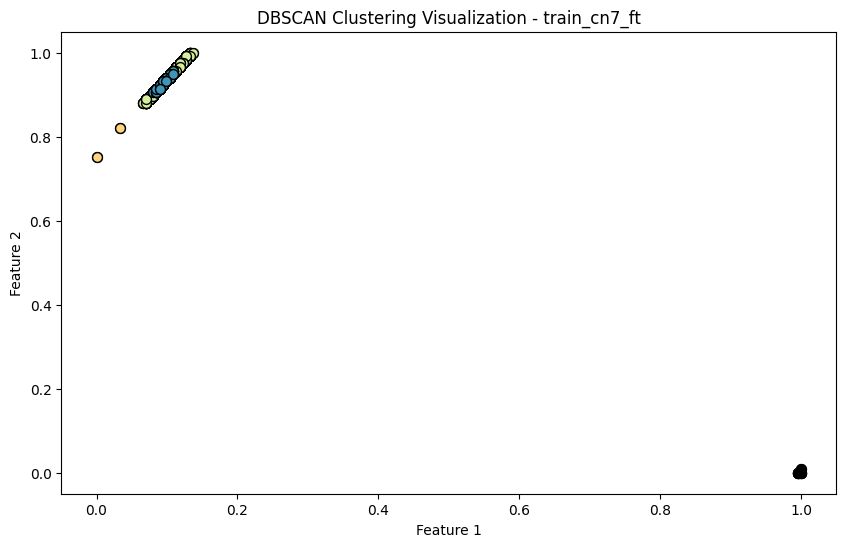

In [ ]:
model = DBSCAN(eps=1.076, min_samples=10)
labels = model.fit_predict(train_cn7_ft)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(10, 6))
for label, color in zip(unique_labels, colors):
    if label == -1:  # 노이즈는 검은색으로 표시
        color = [0, 0, 0, 1]

    # 클러스터 별 포인트 필터링
    class_member_mask = (labels == label)
    xy = train_cn7_ft[class_member_mask]

    plt.scatter(xy[:, 0], xy[:, 1], marker='o', c=[color], edgecolor='k', s=50)

plt.title('DBSCAN Clustering Visualization - train_cn7_ft')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

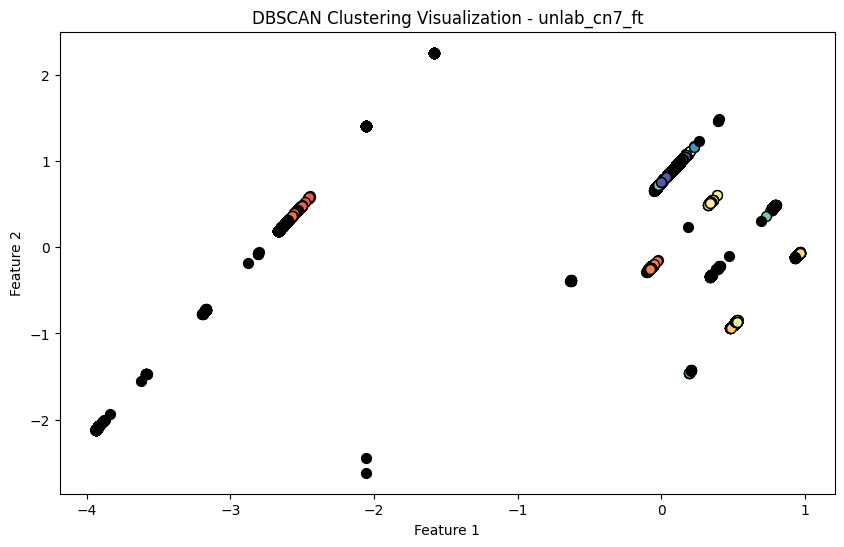

In [ ]:
model = DBSCAN(eps=0.6, min_samples=10)
model.fit(train_cn7_ft)
labels = model.fit_predict(unlab_cn7_ft)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(10, 6))
for label, color in zip(unique_labels, colors):
    if label == -1:  # 노이즈는 검은색으로 표시
        color = [0, 0, 0, 1]

    # 클러스터 별 포인트 필터링
    class_member_mask = (labels == label)
    xy = unlab_cn7_ft[class_member_mask]

    plt.scatter(xy[:, 0], xy[:, 1], marker='o', c=[color], edgecolor='k', s=50)

plt.title('DBSCAN Clustering Visualization - unlab_cn7_ft')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:
model = DBSCAN(eps=1.076,
               min_samples=10,
               metric='euclidean',
               n_jobs=-1)

model.fit(train_cn7_ft)

pred_dbscan = model.fit_predict(unlab_cn7_ft)

normal = unlab_cn7_ft[pred_dbscan != -1]
anomalies = unlab_cn7_ft[pred_dbscan == -1]
ratio = len(anomalies) / len(unlab_cn7_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

data = unlab_cn7_ft[pred_dbscan != -1]
labels = pred_dbscan[pred_dbscan != -1]

sil_score = silhouette_score(data, labels)
print(f"Silhouette Score: {sil_score:.4f}")

정상 : 52487, 이상치 : 60, 이상치 비율 : 0.0011
Silhouette Score: 0.5855


In [ ]:
unsupervised_label = np.where(pred_dbscan == -1, 1, 0)

train_ft = np.concatenate([train_cn7_ft, unlab_cn7_ft])
target = np.concatenate([tr_target_cn7, unsupervised_label], axis=0)

model = LogisticRegression(random_state=SEED)
model.fit(train_ft, target)
pred = model.predict(test_cn7_ft)
print(classification_report(target_cn7, pred))  # target_cn7에 대한 평가
print(f"ROC AUC Score: {roc_auc_score(target_cn7, pred):.4f}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1546
           1       0.00      0.00      0.00        28

    accuracy                           0.98      1574
   macro avg       0.49      0.50      0.50      1574
weighted avg       0.96      0.98      0.97      1574

ROC AUC Score: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

# F1 매크로 스코어와 ROC AUC를 저장할 리스트
f1_scores = []
roc_auc_scores = []
models = []

# Stratified K-Fold 교차 검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 루프
for tri, vai in cv.split(train_ft, target):
    # 학습 데이터와 검증 데이터 분리
    x_train = train_ft[tri]
    y_train = target[tri]
    x_valid = train_ft[vai]
    y_valid = target[vai]

    # 모델 초기화 및 학습
    model = XGBClassifier()
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=False)

    # 모델 저장
    models.append(model)

    # 예측 및 F1 매크로 스코어 계산
    pred = model.predict(x_valid)
    f1 = f1_score(y_valid, pred, average='macro')
    f1_scores.append(f1)

    # 예측 확률을 사용하여 ROC AUC 계산
    pred_prob = model.predict_proba(x_valid)[:, 1]  # 클래스 1에 대한 예측 확률
    roc_auc = roc_auc_score(y_valid, pred_prob)
    roc_auc_scores.append(roc_auc)

# F1 매크로 스코어의 평균 출력
print("Mean F1 Macro Score:", np.mean(f1_scores))

# ROC AUC의 평균 출력
print("Mean ROC AUC Score:", np.mean(roc_auc_scores))

Mean F1 Macro Score: 0.9065459633511317
Mean ROC AUC Score: 0.9913519367875743


In [ ]:
pred_dbscan = model.fit_predict(test_cn7_ft)
pred_dbscan = (pred_dbscan == -1).astype(int)
print(classification_report(target_cn7, pred_dbscan))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1546
           1       0.74      0.61      0.67        28

    accuracy                           0.99      1574
   macro avg       0.87      0.80      0.83      1574
weighted avg       0.99      0.99      0.99      1574



### RG3

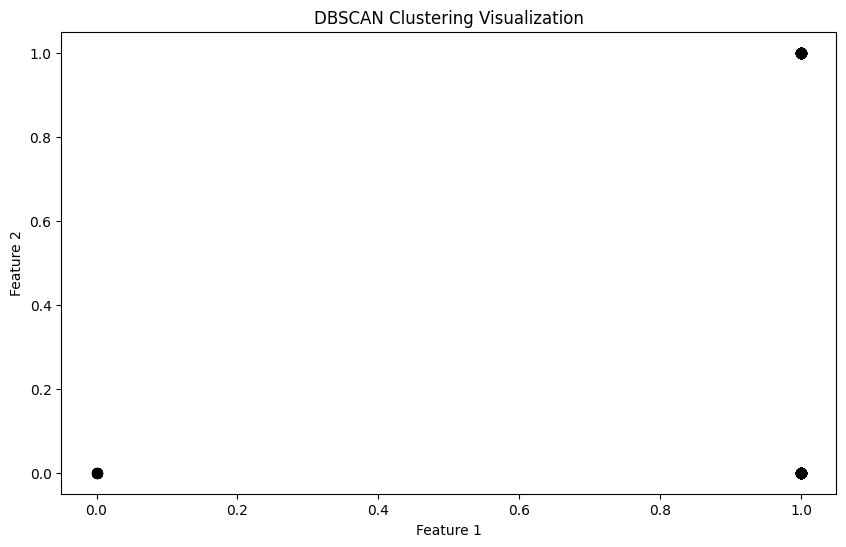

In [ ]:
model = DBSCAN(eps=0.5, min_samples=10)
labels = model.fit_predict(train_rg3_ft)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(10, 6))
for label, color in zip(unique_labels, colors):
    if label == -1:  # 노이즈는 검은색으로 표시
        color = [0, 0, 0, 1]

    # 클러스터 별 포인트 필터링
    class_member_mask = (labels == label)
    xy = train_rg3_ft[class_member_mask]

    plt.scatter(xy[:, 0], xy[:, 1], marker='o', c=[color], edgecolor='k', s=50)

plt.title('DBSCAN Clustering Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

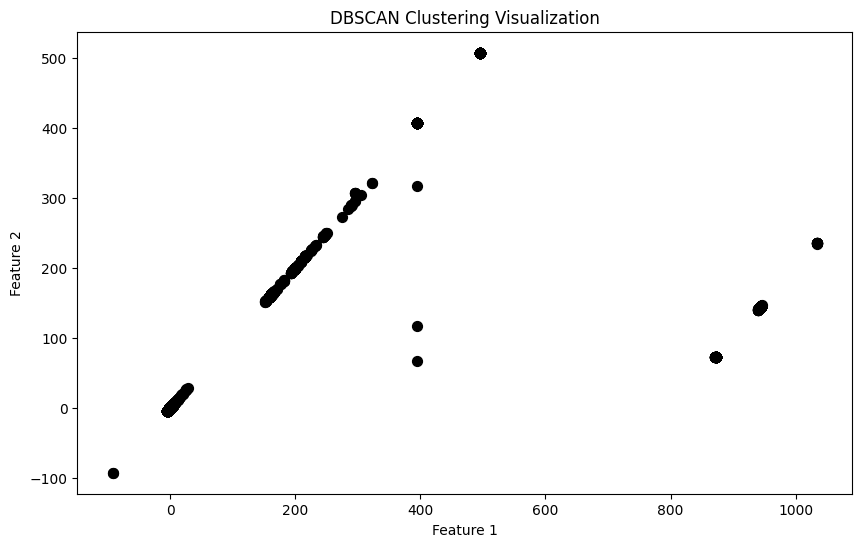

In [ ]:
model = DBSCAN(eps=0.5, min_samples=10)
model.fit(train_rg3_ft)
labels = model.fit_predict(unlab_rg3_ft)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(10, 6))
for label, color in zip(unique_labels, colors):
    if label == -1:  # 노이즈는 검은색으로 표시
        color = [0, 0, 0, 1]

    # 클러스터 별 포인트 필터링
    class_member_mask = (labels == label)
    xy = unlab_rg3_ft[class_member_mask]

    plt.scatter(xy[:, 0], xy[:, 1], marker='o', c=[color], edgecolor='k', s=50)

plt.title('DBSCAN Clustering Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:
model = DBSCAN(eps=0.5,
                   min_samples=10,
                   metric='euclidean',
                   n_jobs=-1)

model.fit(train_rg3_ft)

pred_dbscan = model.fit_predict(unlab_rg3_ft)

normal = unlab_rg3_ft[pred_dbscan != -1]
anomalies = unlab_rg3_ft[pred_dbscan == -1]
ratio = len(anomalies) / len(unlab_rg3_ft)

print(f"정상 : {len(normal)}, 이상치 : {len(anomalies)}, 이상치 비율 : {ratio:.4f}")

data = unlab_rg3_ft[pred_dbscan != -1]
labels = pred_dbscan[pred_dbscan != -1]

sil_score = silhouette_score(data, labels)
print(f"Silhouette Score: {sil_score:.4f}")

정상 : 12995, 이상치 : 24482, 이상치 비율 : 0.6533
Silhouette Score: 0.2033


In [ ]:
pred_dbscan = model.fit_predict(test_rg3_ft)
pred_dbscan = (pred_dbscan == -1).astype(int)
print(classification_report(target_rg3, pred_dbscan))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       474
           1       0.06      1.00      0.12        32

    accuracy                           0.06       506
   macro avg       0.03      0.50      0.06       506
weighted avg       0.00      0.06      0.01       506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Gaussian Mixture Model (GMM)

### CN7

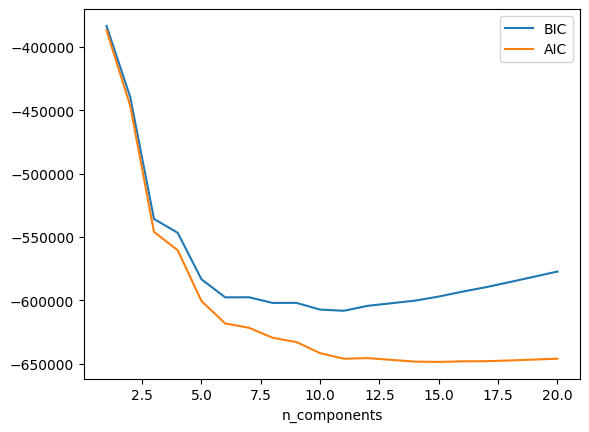

In [ ]:
# n_components = np.arange(1, 21)
# models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(train_cn7_ft) for n in n_components]
# plt.plot(n_components, [m.bic(train_cn7_ft) for m in models], label='BIC')
# plt.plot(n_components, [m.aic(train_cn7_ft) for m in models], label='AIC')
# plt.legend(loc='best')
# plt.xlabel('n_components');

In [ ]:
model = GaussianMixture(n_components=11,
                            covariance_type='full',
                            random_state=SEED)
model.fit(train_cn7_ft)

# 작은 값일수록 좋음
aic = model.aic(train_cn7_ft)
bic = model.bic(train_cn7_ft)

print(f"AIC: {aic}")
print(f"BIC: {bic}")

log_likelihood = model.score_samples(unlab_cn7_ft)  # 각 샘플의 log-likelihood 값
log_likelihood.mean() # 큰 값일수록 좋음

AIC: -646077.874453798
BIC: -608232.456490895


-4151072096.4810076

In [ ]:
threshold = np.percentile(log_likelihood, 1)

# 이상치 판별
anomalies = unlab_cn7_ft[log_likelihood < threshold]

# 이상치 탐지 비율 계산
anomaly_ratio = len(anomalies) / len(unlab_cn7_ft)
print(f"전체 데이터 중 이상치 비율: {anomaly_ratio:.4f}")

전체 데이터 중 이상치 비율: 0.0100


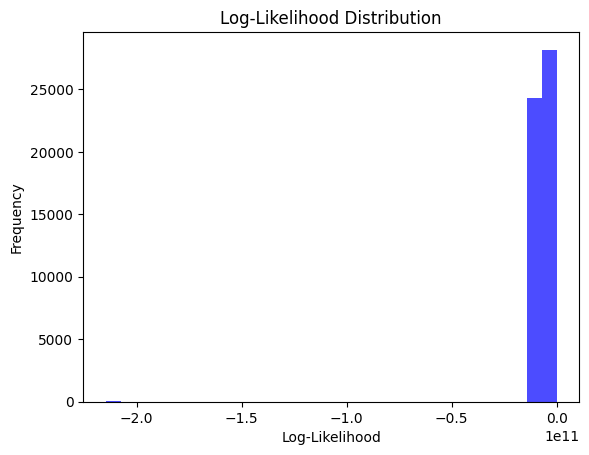

In [ ]:
# 로그 가능도 분포
plt.hist(log_likelihood, bins=30, color='blue', alpha=0.7)
plt.title('Log-Likelihood Distribution')
plt.xlabel('Log-Likelihood')
plt.ylabel('Frequency')
plt.show()

In [ ]:
model = GaussianMixture(n_components=11,
                        covariance_type='full',
                        random_state=SEED)
model.fit(train_cn7_ft)

# AIC와 BIC 계산
aic = model.aic(train_cn7_ft)
bic = model.bic(train_cn7_ft)
print(f"AIC: {aic}")
print(f"BIC: {bic}")

# 각 샘플의 log-likelihood 값 계산
log_likelihood = model.score_samples(unlab_cn7_ft)
print(f"Log-likelihood 평균값: {log_likelihood.mean()}")

# 1% 분위수 기준으로 이상치 탐지
threshold = np.percentile(log_likelihood, 1)

# 이상치 판별
anomalies = unlab_cn7_ft[log_likelihood < threshold]

# 이상치 비율 계산
anomaly_ratio = len(anomalies) / len(unlab_cn7_ft)
print(f"전체 데이터 중 이상치 비율: {anomaly_ratio:.4f}")

# 이상치 레이블링 (이상치: 1, 정상: 0)
unsupervised_label = np.where(log_likelihood < threshold, 1, 0)

# train 데이터와 unlab 데이터를 결합
train_ft = np.concatenate([train_cn7_ft, unlab_cn7_ft])
target = np.concatenate([tr_target_cn7, unsupervised_label])

# 로지스틱 회귀 모델 학습
model = LogisticRegression(random_state=SEED)
model.fit(train_ft, target)

# 예측
pred = model.predict(test_cn7_ft)

# 성능 평가
print(classification_report(target_cn7, pred))  # target_cn7에 대한 평가
print(f"ROC AUC Score: {roc_auc_score(target_cn7, pred):.4f}")

AIC: -646077.874453798
BIC: -608232.456490895
Log-likelihood 평균값: -4151072096.4810076
전체 데이터 중 이상치 비율: 0.0100
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1546
           1       0.00      0.00      0.00        28

    accuracy                           0.98      1574
   macro avg       0.49      0.50      0.50      1574
weighted avg       0.96      0.98      0.97      1574

ROC AUC Score: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

### RG3

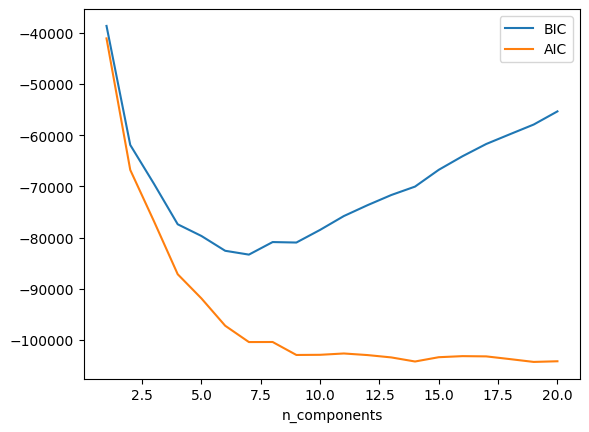

In [ ]:
# n_components = np.arange(1, 21)
# models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(train_rg3_ft) for n in n_components]
# plt.plot(n_components, [m.bic(train_rg3_ft) for m in models], label='BIC')
# plt.plot(n_components, [m.aic(train_rg3_ft) for m in models], label='AIC')
# plt.legend(loc='best')
# plt.xlabel('n_components');

In [ ]:
model = GaussianMixture(n_components=7,
                            covariance_type='full',
                            random_state=SEED)
model.fit(train_rg3_ft)

# 작은 값일수록 좋음
aic = model.aic(train_rg3_ft)
bic = model.bic(train_rg3_ft)

print(f"AIC: {aic}")
print(f"BIC: {bic}")

log_likelihood = model.score_samples(unlab_rg3_ft)  # 각 샘플의 log-likelihood 값
log_likelihood.mean() # 큰 값일수록 좋음

AIC: -99529.24405578103
BIC: -82458.07355765137


-79466690689.3037

In [ ]:
threshold = np.percentile(log_likelihood, 1)

# 이상치 판별
anomalies = unlab_cn7_ft[log_likelihood < threshold]

# 이상치 탐지 비율 계산
anomaly_ratio = len(anomalies) / len(unlab_cn7_ft)
print(f"전체 데이터 중 이상치 비율: {anomaly_ratio:.4f}")

전체 데이터 중 이상치 비율: 0.0100


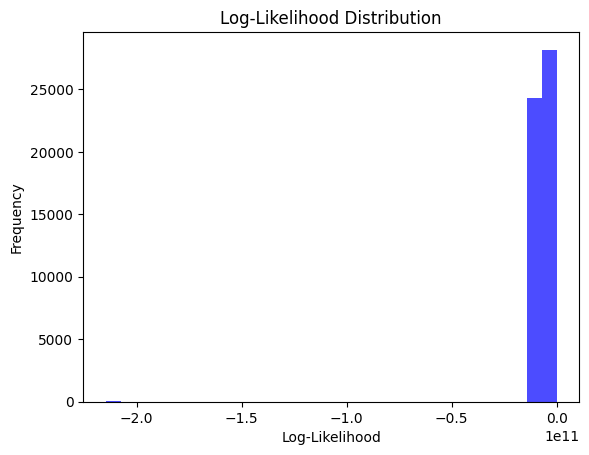

In [ ]:
# 로그 가능도 분포
plt.hist(log_likelihood, bins=30, color='blue', alpha=0.7)
plt.title('Log-Likelihood Distribution')
plt.xlabel('Log-Likelihood')
plt.ylabel('Frequency')
plt.show()

## k-Means Clustering

### CN7

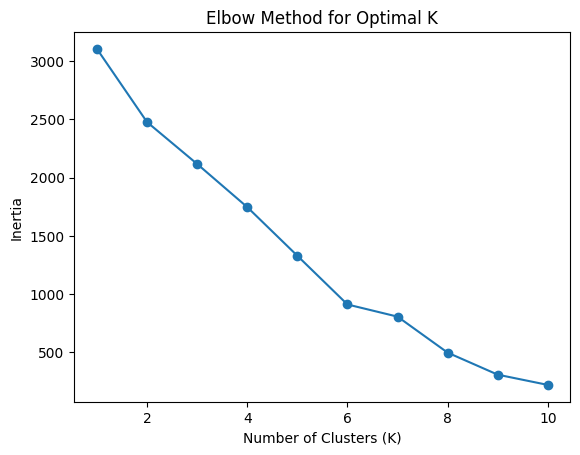

In [ ]:
# inertia_values = []
# K_range = range(1, 11)  # 1부터 10까지 클러스터 수를 테스트

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=SEED)
#     kmeans.fit(train_cn7_ft)  # 정상 데이터로 학습
#     inertia_values.append(kmeans.inertia_)

# # Elbow Method 시각화
# plt.plot(K_range, inertia_values, marker='o')
# plt.xlabel('Number of Clusters (K)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal K')
# plt.show()

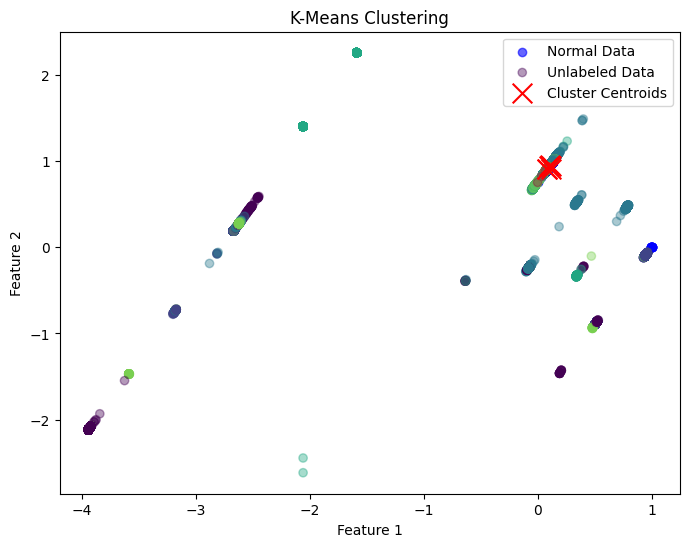

In [ ]:
model = KMeans(n_clusters=6, random_state=SEED)
model.fit(train_cn7_ft)

cluster_labels = model.predict(unlab_cn7_ft)

# 군집 중심
centroids = model.cluster_centers_

# 군집화된 데이터 시각화
plt.figure(figsize=(8, 6))

# 정상 데이터와 예측된 레이블에 따라 색상 지정
plt.scatter(train_cn7_ft[:, 0], train_cn7_ft[:, 1], c='blue', label='Normal Data', alpha=0.6)  # 정상 데이터 (train_ft)
plt.scatter(unlab_cn7_ft[:, 0], unlab_cn7_ft[:, 1], c=cluster_labels, cmap='viridis', label='Unlabeled Data', alpha=0.4)  # 레이블이 없는 데이터

# 군집 중심 표시
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Cluster Centroids')

plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [ ]:
distances = model.transform(unlab_cn7_ft)   # 클러스터 중심간의 거리
min_distances = distances[:, 0]

threshold = 300
is_anomaly = min_distances > threshold

normal_data = unlab_cn7_ft[~is_anomaly]
anomalies = unlab_cn7_ft[is_anomaly]
ratio = len(anomalies) / len(unlab_cn7_ft)

# 결과 출력
print(f"정상 데이터 개수: {len(normal_data)}")
print(f"이상치 데이터 개수: {len(anomalies)}")
print(f"이상치 비율 : {ratio:.4f}")

# 정상 데이터만으로 KMeans 클러스터링 후 실루엣 점수 계산
sil_score = silhouette_score(train_cn7_ft, model.labels_)
print(f"Silhouette Score: {sil_score:.4f}")

정상 데이터 개수: 28173
이상치 데이터 개수: 24374
이상치 비율 : 0.4639
Silhouette Score: 0.6159


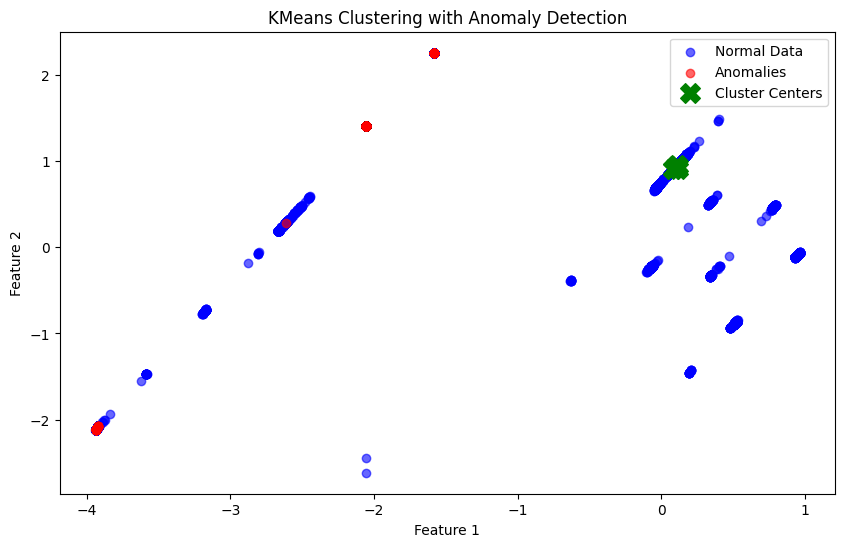

In [ ]:
# KMeans 클러스터링 결과
cluster_centers = model.cluster_centers_

# 시각화
plt.figure(figsize=(10, 6))

# 1. 정상 데이터 시각화
plt.scatter(normal_data[:, 0], normal_data[:, 1], c='blue', label="Normal Data", alpha=0.6)

# 2. 이상치 데이터 시각화
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='red', label="Anomalies", alpha=0.6)

# 3. 클러스터 중심 시각화
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='green', s=200, marker='X', label="Cluster Centers")

# 그래프 설정
plt.title("KMeans Clustering with Anomaly Detection")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [ ]:
distances = model.transform(test_cn7_ft)  # 클러스터 중심간의 거리
min_distances = distances[:, 0]

# 예측 레이블: 0 (정상), 1 (이상치)
pred_kmeans = (min_distances > threshold).astype(int)  # 이상치 기준 적용

print(classification_report(target_cn7, pred_kmeans))

roc_auc = roc_auc_score(target_cn7, min_distances)
print(f"ROC-AUC Score: {roc_auc}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1546
           1       0.00      0.00      0.00        28

    accuracy                           0.98      1574
   macro avg       0.49      0.50      0.50      1574
weighted avg       0.96      0.98      0.97      1574

ROC-AUC Score: 0.7005983182406209


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model = KMeans(n_clusters=6, random_state=SEED)
model.fit(train_cn7_ft)

distances = model.transform(unlab_cn7_ft)  # 클러스터 중심간의 거리
min_distances = distances[:, 0]

threshold = 300
pred_kmeans = (min_distances >= threshold).astype(int)

train_ft = np.concatenate([train_cn7_ft, unlab_cn7_ft])
target = np.concatenate([tr_target_cn7, pred_kmeans], axis=0)

model = LogisticRegression(random_state=SEED)
model.fit(train_ft, target)
pred = model.predict(test_cn7_ft)
print(classification_report(target_cn7, pred))  # target_cn7에 대한 평가
print(f"ROC AUC Score: {roc_auc_score(target_cn7, pred):.4f}")

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

# F1 매크로 스코어, ROC AUC, Recall을 저장할 리스트
f1_scores = []
roc_auc_scores = []
recall_scores = []
models = []

# Stratified K-Fold 교차 검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 루프
for tri, vai in cv.split(train_ft, target):
    # 학습 데이터와 검증 데이터 분리
    x_train = train_ft[tri]
    y_train = target[tri]
    x_valid = train_ft[vai]
    y_valid = target[vai]

    # 모델 초기화 및 학습
    model = XGBClassifier()
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=False)

    # 모델 저장
    models.append(model)

    # 예측
    pred = model.predict(x_valid)

    # F1 매크로 스코어 계산
    f1 = f1_score(y_valid, pred, average='macro')
    f1_scores.append(f1)

    # ROC AUC 계산 (예측 확률을 사용)
    pred_prob = model.predict_proba(x_valid)[:, 1]  # 클래스 1에 대한 예측 확률
    roc_auc = roc_auc_score(y_valid, pred_prob)
    roc_auc_scores.append(roc_auc)

    # Recall 계산
    recall = recall_score(y_valid, pred)
    recall_scores.append(recall)

# F1 매크로 스코어의 평균 출력
print("Mean F1 Macro Score:", np.mean(f1_scores))

# ROC AUC의 평균 출력
print("Mean ROC AUC Score:", np.mean(roc_auc_scores))

Mean F1 Macro Score: 0.9999815665913303
Mean ROC AUC Score: 0.9999794871794873


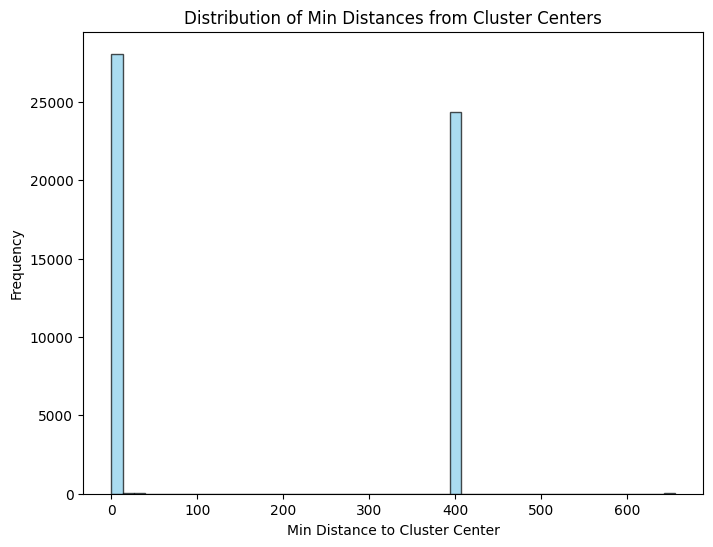

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(min_distances, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Min Distances from Cluster Centers")
plt.xlabel("Min Distance to Cluster Center")
plt.ylabel("Frequency")
plt.show()

#### K-Means 시각화

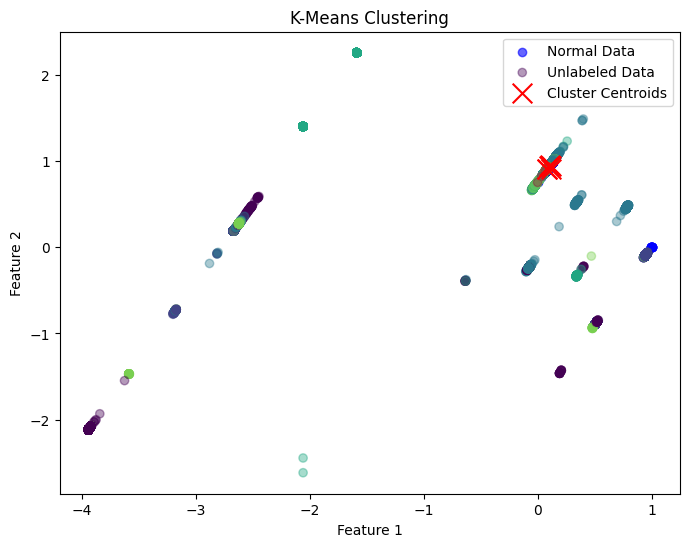

In [ ]:
# 군집 예측
cluster_labels = model.predict(unlab_cn7_ft)

# 군집 중심
centroids = model.cluster_centers_

# 군집화된 데이터 시각화
plt.figure(figsize=(8, 6))

# 정상 데이터와 예측된 레이블에 따라 색상 지정
plt.scatter(train_cn7_ft[:, 0], train_cn7_ft[:, 1], c='blue', label='Normal Data', alpha=0.6)  # 정상 데이터 (train_ft)
plt.scatter(unlab_cn7_ft[:, 0], unlab_cn7_ft[:, 1], c=cluster_labels, cmap='viridis', label='Unlabeled Data', alpha=0.4)  # 레이블이 없는 데이터

# 군집 중심 표시
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Cluster Centroids')

plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

### RG3

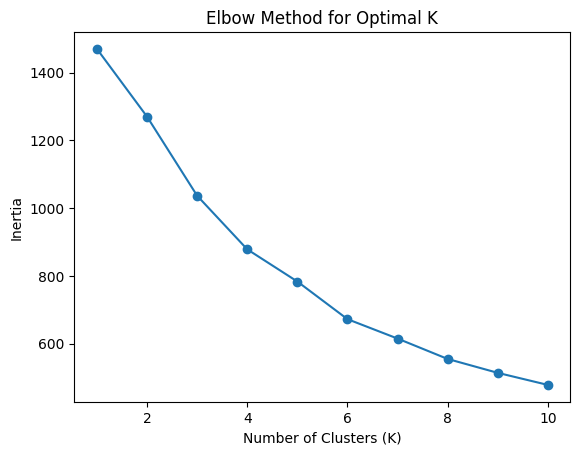

In [ ]:
# inertia_values = []
# K_range = range(1, 11)  # 1부터 10까지 클러스터 수를 테스트

# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=SEED)
#     kmeans.fit(train_rg3_ft)  # 정상 데이터로 학습
#     inertia_values.append(kmeans.inertia_)

# # Elbow Method 시각화
# plt.plot(K_range, inertia_values, marker='o')
# plt.xlabel('Number of Clusters (K)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Optimal K')
# plt.show()

In [ ]:
model = KMeans(n_clusters=6, random_state=SEED)
model.fit(train_rg3_ft)

distances = model.transform(unlab_rg3_ft)   # 클러스터 중심간의 거리
min_distances = distances[:, 0]

threshold = np.percentile(min_distances, 99)  # 예: 상위 5%를 이상치로 간주
is_anomaly = min_distances > threshold

normal_data = unlab_rg3_ft[~is_anomaly]
anomalies = unlab_rg3_ft[is_anomaly]
ratio = len(anomalies) / len(unlab_rg3_ft)

# 결과 출력
print(f"정상 데이터 개수: {len(normal_data)}")
print(f"이상치 데이터 개수: {len(anomalies)}")
print(f"이상치 비율 : {ratio:.4f}")

# 정상 데이터만으로 KMeans 클러스터링 후 실루엣 점수 계산
sil_score = silhouette_score(train_rg3_ft, model.labels_)
print(f"Silhouette Score: {sil_score:.4f}")

정상 데이터 개수: 37102
이상치 데이터 개수: 375
이상치 비율 : 0.0100
Silhouette Score: 0.2842


In [ ]:
distances = model.transform(test_rg3_ft)  # 클러스터 중심간의 거리
min_distances = distances[:, 0]

# 예측 레이블: 0 (정상), 1 (이상치)
pred_labels = (min_distances > threshold).astype(int)  # 이상치 기준 적용

print(classification_report(target_rg3, pred_labels))

roc_auc = roc_auc_score(target_rg3, min_distances)
print(f"ROC-AUC Score: {roc_auc}")

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       474
           1       0.00      0.00      0.00        32

    accuracy                           0.94       506
   macro avg       0.47      0.50      0.48       506
weighted avg       0.88      0.94      0.91       506

ROC-AUC Score: 0.31882911392405067


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### K-Means 시각화

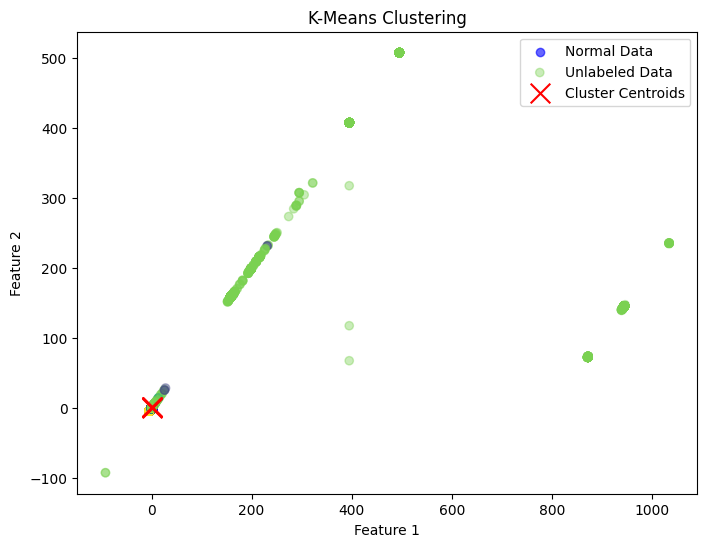

In [ ]:
# 군집 예측
cluster_labels = model.predict(unlab_rg3_ft)

# 군집 중심
centroids = model.cluster_centers_

# 군집화된 데이터 시각화
plt.figure(figsize=(8, 6))

# 정상 데이터와 예측된 레이블에 따라 색상 지정
plt.scatter(train_rg3_ft[:, 0], train_rg3_ft[:, 1], c='blue', label='Normal Data', alpha=0.6)  # 정상 데이터 (train_ft)
plt.scatter(unlab_rg3_ft[:, 0], unlab_rg3_ft[:, 1], c=cluster_labels, cmap='viridis', label='Unlabeled Data', alpha=0.4)  # 레이블이 없는 데이터

# 군집 중심 표시
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Cluster Centroids')

plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

## 오토인코더

In [ ]:
train_cn7_ft = torch.tensor(train_cn7_ft, dtype=torch.float32).to(device)
test_cn7_ft = torch.tensor(test_cn7_ft, dtype=torch.float32).to(device)
unlab_cn7_ft = torch.tensor(unlab_cn7_ft, dtype=torch.float32).to(device)

train_cn7_ft.shape, test_cn7_ft.shape, unlab_cn7_ft.shape

(torch.Size([2400, 33]), torch.Size([1574, 33]), torch.Size([52547, 33]))

In [ ]:
train_rg3_ft = torch.tensor(train_rg3_ft, dtype=torch.float32).to(device)
test_rg3_ft = torch.tensor(test_rg3_ft, dtype=torch.float32).to(device)
unlab_rg3_ft = torch.tensor(unlab_rg3_ft, dtype=torch.float32).to(device)

train_rg3_ft.shape, test_rg3_ft.shape, unlab_rg3_ft.shape

(torch.Size([750, 31]), torch.Size([506, 31]), torch.Size([37477, 31]))

In [ ]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, in_features, hidden_size):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(in_features, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size//2),
            torch.nn.ReLU(),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(hidden_size//2, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, in_features),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
reset_seeds(SEED)

num_epochs = 50
batch_size = 32
loss_fn = torch.nn.BCEWithLogitsLoss()

### CN7

In [ ]:
# 학습
X_tensor = torch.Tensor(train_cn7_ft)
y_tensor = torch.Tensor(target_cn7)

dataset = torch.utils.data.TensorDataset(X_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

auto_encoder = AutoEncoder(train_cn7_ft.shape[1], 64)
optimizer = torch.optim.Adam(auto_encoder.parameters())

for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = auto_encoder(inputs)
        loss = loss_fn(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 재구성 오류 계산
with torch.no_grad():
    reconstructed = auto_encoder(X_tensor)
    reconstruction_error = torch.mean((X_tensor - reconstructed) ** 2, dim=1).numpy()

# 이상치 탐지 기준 설정 (상위 5%를 이상치로 간주)
threshold = np.percentile(reconstruction_error, 95)
y_pred = (reconstruction_error > threshold).astype(int)

Epoch [1/50], Loss: 0.2927
Epoch [2/50], Loss: 0.2967
Epoch [3/50], Loss: 0.2647
Epoch [4/50], Loss: 0.2207
Epoch [5/50], Loss: 0.1995
Epoch [6/50], Loss: 0.1891
Epoch [7/50], Loss: 0.1822
Epoch [8/50], Loss: 0.1763
Epoch [9/50], Loss: 0.1768
Epoch [10/50], Loss: 0.1800
Epoch [11/50], Loss: 0.1811
Epoch [12/50], Loss: 0.1767
Epoch [13/50], Loss: 0.1773
Epoch [14/50], Loss: 0.1776
Epoch [15/50], Loss: 0.1731
Epoch [16/50], Loss: 0.1745
Epoch [17/50], Loss: 0.1744
Epoch [18/50], Loss: 0.1764
Epoch [19/50], Loss: 0.1782
Epoch [20/50], Loss: 0.1777
Epoch [21/50], Loss: 0.1790
Epoch [22/50], Loss: 0.1755
Epoch [23/50], Loss: 0.1743
Epoch [24/50], Loss: 0.1784
Epoch [25/50], Loss: 0.1766
Epoch [26/50], Loss: 0.1777
Epoch [27/50], Loss: 0.1734
Epoch [28/50], Loss: 0.1808
Epoch [29/50], Loss: 0.1751
Epoch [30/50], Loss: 0.1808
Epoch [31/50], Loss: 0.1757
Epoch [32/50], Loss: 0.1733
Epoch [33/50], Loss: 0.1758
Epoch [34/50], Loss: 0.1758
Epoch [35/50], Loss: 0.1768
Epoch [36/50], Loss: 0.1735
E

In [ ]:
auto_encoder.eval()
with torch.no_grad():
    # unlab_ft 데이터에 대해 복원을 수행
    reconstructions = auto_encoder(unlab_cn7_ft)  # unlab_ft를 모델에 넣어 복원
    # 복원 오차 계산 (각 샘플에 대해 평균 제곱 오차)
    reconstruction_errors = torch.mean((unlab_cn7_ft - reconstructions) ** 2, dim=1)

# 이상치 판단: 복원 오차가 임계값보다 큰 경우를 이상치로 간주
threshold = torch.quantile(reconstruction_errors, 0.95)  # 상위 5%를 이상치로 간주
is_anomaly = reconstruction_errors > threshold  # 이상치 여부 판단

print(f"이상치 샘플 수: {is_anomaly.sum().item()}")
print(f"이상치 비율 : {is_anomaly.sum().item()/len(unlab_cn7_ft):.4f}")

이상치 샘플 수: 2627
이상치 비율 : 0.0500


### RG3

In [ ]:
# 학습
X_tensor = torch.Tensor(train_rg3_ft)
y_tensor = torch.Tensor(target_rg3)

dataset = torch.utils.data.TensorDataset(X_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

auto_encoder = AutoEncoder(train_rg3_ft.shape[1], 64)
optimizer = torch.optim.Adam(auto_encoder.parameters())

for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = auto_encoder(inputs)
        loss = loss_fn(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 재구성 오류 계산
with torch.no_grad():
    reconstructed = auto_encoder(X_tensor)
    reconstruction_error = torch.mean((X_tensor - reconstructed) ** 2, dim=1).numpy()

# 이상치 탐지 기준 설정 (상위 5%를 이상치로 간주)
threshold = np.percentile(reconstruction_error, 95)
y_pred = (reconstruction_error > threshold).astype(int)

Epoch [1/50], Loss: 0.6391
Epoch [2/50], Loss: 0.5671
Epoch [3/50], Loss: 0.5467
Epoch [4/50], Loss: 0.5345
Epoch [5/50], Loss: 0.5041
Epoch [6/50], Loss: 0.5028
Epoch [7/50], Loss: 0.4785
Epoch [8/50], Loss: 0.4407
Epoch [9/50], Loss: 0.4204
Epoch [10/50], Loss: 0.4357
Epoch [11/50], Loss: 0.4363
Epoch [12/50], Loss: 0.4396
Epoch [13/50], Loss: 0.4541
Epoch [14/50], Loss: 0.4111
Epoch [15/50], Loss: 0.4334
Epoch [16/50], Loss: 0.4078
Epoch [17/50], Loss: 0.4054
Epoch [18/50], Loss: 0.4174
Epoch [19/50], Loss: 0.4157
Epoch [20/50], Loss: 0.4211
Epoch [21/50], Loss: 0.4051
Epoch [22/50], Loss: 0.3971
Epoch [23/50], Loss: 0.4032
Epoch [24/50], Loss: 0.3964
Epoch [25/50], Loss: 0.4092
Epoch [26/50], Loss: 0.4006
Epoch [27/50], Loss: 0.4029
Epoch [28/50], Loss: 0.4117
Epoch [29/50], Loss: 0.3981
Epoch [30/50], Loss: 0.4125
Epoch [31/50], Loss: 0.3994
Epoch [32/50], Loss: 0.4031
Epoch [33/50], Loss: 0.4012
Epoch [34/50], Loss: 0.3977
Epoch [35/50], Loss: 0.3965
Epoch [36/50], Loss: 0.4008
E

In [ ]:
auto_encoder.eval()
with torch.no_grad():
    # unlab_ft 데이터에 대해 복원을 수행
    reconstructions = auto_encoder(unlab_rg3_ft)  # unlab_ft를 모델에 넣어 복원
    # 복원 오차 계산 (각 샘플에 대해 평균 제곱 오차)
    reconstruction_errors = torch.mean((unlab_rg3_ft - reconstructions) ** 2, dim=1)

# 이상치 판단: 복원 오차가 임계값보다 큰 경우를 이상치로 간주
threshold = torch.quantile(reconstruction_errors, 0.95)  # 상위 5%를 이상치로 간주
is_anomaly = reconstruction_errors > threshold  # 이상치 여부 판단

print(f"이상치 샘플 수: {is_anomaly.sum().item()}")
print(f"이상치 비율 : {is_anomaly.sum().item()/len(unlab_rg3_ft):.4f}")

이상치 샘플 수: 1874
이상치 비율 : 0.0500


## Dense 오토인코더

In [ ]:
class DenseAutoencoder(torch.nn.Module):
    def __init__(self, in_features, hidden_size, latent_dim):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(in_features, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size//2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size//2, latent_dim),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_size//2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size//2, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, in_features),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
reset_seeds(SEED)

num_epochs = 50
batch_size = 32
loss_fn = torch.nn.BCEWithLogitsLoss()

### CN7

In [ ]:
# 학습
X_tensor = torch.Tensor(train_cn7_ft)
y_tensor = torch.Tensor(target_cn7)

dataset = torch.utils.data.TensorDataset(X_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

dense_ae = DenseAutoencoder(train_cn7_ft.shape[1], 128, 16)
optimizer = torch.optim.Adam(dense_ae.parameters())

for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = dense_ae(inputs)
        loss = loss_fn(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 재구성 오류 계산
with torch.no_grad():
    reconstructed = dense_ae(X_tensor)
    reconstruction_error = torch.mean((X_tensor - reconstructed) ** 2, dim=1).numpy()

# 이상치 탐지 기준 설정 (상위 5%를 이상치로 간주)
threshold = np.percentile(reconstruction_error, 95)
y_pred = (reconstruction_error > threshold).astype(int)

Epoch [1/50], Loss: 0.3032
Epoch [2/50], Loss: 0.2972
Epoch [3/50], Loss: 0.2863
Epoch [4/50], Loss: 0.2245
Epoch [5/50], Loss: 0.1979
Epoch [6/50], Loss: 0.1858
Epoch [7/50], Loss: 0.1745
Epoch [8/50], Loss: 0.1778
Epoch [9/50], Loss: 0.1807
Epoch [10/50], Loss: 0.1823
Epoch [11/50], Loss: 0.1819
Epoch [12/50], Loss: 0.1757
Epoch [13/50], Loss: 0.1786
Epoch [14/50], Loss: 0.1807
Epoch [15/50], Loss: 0.1792
Epoch [16/50], Loss: 0.1798
Epoch [17/50], Loss: 0.1726
Epoch [18/50], Loss: 0.1775
Epoch [19/50], Loss: 0.1768
Epoch [20/50], Loss: 0.1786
Epoch [21/50], Loss: 0.1752
Epoch [22/50], Loss: 0.1717
Epoch [23/50], Loss: 0.1778
Epoch [24/50], Loss: 0.1783
Epoch [25/50], Loss: 0.1767
Epoch [26/50], Loss: 0.1745
Epoch [27/50], Loss: 0.1794
Epoch [28/50], Loss: 0.1818
Epoch [29/50], Loss: 0.1789
Epoch [30/50], Loss: 0.1737
Epoch [31/50], Loss: 0.1731
Epoch [32/50], Loss: 0.1732
Epoch [33/50], Loss: 0.1753
Epoch [34/50], Loss: 0.1808
Epoch [35/50], Loss: 0.1807
Epoch [36/50], Loss: 0.1783
E

In [ ]:
dense_ae.eval()
with torch.no_grad():
    # unlab_ft 데이터에 대해 복원을 수행
    reconstructions = dense_ae(unlab_cn7_ft)  # unlab_ft를 모델에 넣어 복원
    # 복원 오차 계산 (각 샘플에 대해 평균 제곱 오차)
    reconstruction_errors = torch.mean((unlab_cn7_ft - reconstructions) ** 2, dim=1)

# 이상치 판단: 복원 오차가 임계값보다 큰 경우를 이상치로 간주
threshold = torch.quantile(reconstruction_errors, 0.95)  # 상위 5%를 이상치로 간주
is_anomaly = reconstruction_errors > threshold  # 이상치 여부 판단

print(f"이상치 샘플 수: {is_anomaly.sum().item()}")
print(f"이상치 비율 : {is_anomaly.sum().item()/len(unlab_cn7_ft):.4f}")

이상치 샘플 수: 2628
이상치 비율 : 0.0500


### RG3

In [ ]:
# 학습
X_tensor = torch.Tensor(train_rg3_ft)
y_tensor = torch.Tensor(target_rg3)

dataset = torch.utils.data.TensorDataset(X_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

dense_ae = DenseAutoencoder(train_rg3_ft.shape[1], 128, 16)
optimizer = torch.optim.Adam(dense_ae.parameters())

for epoch in range(num_epochs):
    for batch in dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = dense_ae(inputs)
        loss = loss_fn(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 재구성 오류 계산
with torch.no_grad():
    reconstructed = dense_ae(X_tensor)
    reconstruction_error = torch.mean((X_tensor - reconstructed) ** 2, dim=1).numpy()

# 이상치 탐지 기준 설정 (상위 5%를 이상치로 간주)
threshold = np.percentile(reconstruction_error, 95)
y_pred = (reconstruction_error > threshold).astype(int)

Epoch [1/50], Loss: 0.5964
Epoch [2/50], Loss: 0.5388
Epoch [3/50], Loss: 0.5297
Epoch [4/50], Loss: 0.5412
Epoch [5/50], Loss: 0.5377
Epoch [6/50], Loss: 0.5197
Epoch [7/50], Loss: 0.4961
Epoch [8/50], Loss: 0.4735
Epoch [9/50], Loss: 0.4466
Epoch [10/50], Loss: 0.4425
Epoch [11/50], Loss: 0.4444
Epoch [12/50], Loss: 0.4040
Epoch [13/50], Loss: 0.4182
Epoch [14/50], Loss: 0.4277
Epoch [15/50], Loss: 0.4315
Epoch [16/50], Loss: 0.4347
Epoch [17/50], Loss: 0.4182
Epoch [18/50], Loss: 0.4123
Epoch [19/50], Loss: 0.4141
Epoch [20/50], Loss: 0.4119
Epoch [21/50], Loss: 0.4102
Epoch [22/50], Loss: 0.4034
Epoch [23/50], Loss: 0.4139
Epoch [24/50], Loss: 0.4131
Epoch [25/50], Loss: 0.4035
Epoch [26/50], Loss: 0.4131
Epoch [27/50], Loss: 0.4026
Epoch [28/50], Loss: 0.3953
Epoch [29/50], Loss: 0.3993
Epoch [30/50], Loss: 0.4035
Epoch [31/50], Loss: 0.4063
Epoch [32/50], Loss: 0.4056
Epoch [33/50], Loss: 0.3945
Epoch [34/50], Loss: 0.4096
Epoch [35/50], Loss: 0.4005
Epoch [36/50], Loss: 0.4095
E

In [ ]:
dense_ae.eval()
with torch.no_grad():
    # unlab_ft 데이터에 대해 복원을 수행
    reconstructions = dense_ae(unlab_rg3_ft)  # unlab_ft를 모델에 넣어 복원
    # 복원 오차 계산 (각 샘플에 대해 평균 제곱 오차)
    reconstruction_errors = torch.mean((unlab_rg3_ft - reconstructions) ** 2, dim=1)

# 이상치 판단: 복원 오차가 임계값보다 큰 경우를 이상치로 간주
threshold = torch.quantile(reconstruction_errors, 0.95)  # 상위 5%를 이상치로 간주
is_anomaly = reconstruction_errors > threshold  # 이상치 여부 판단

print(f"이상치 샘플 수: {is_anomaly.sum().item()}")
print(f"이상치 비율 : {is_anomaly.sum().item()/len(unlab_rg3_ft):.4f}")

이상치 샘플 수: 1874
이상치 비율 : 0.0500
